# Logistic Regressions on Telco Churn Data

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pylab import scatter, show, legend, xlabel, ylabel

In [2]:
# Reading the data set
df = pd.read_csv('telco_customer_churn.csv')

In [3]:
# Processing the values and creating dummy data for categorical variables
clustering_df = df.copy()
# Not churn = 0, churn = 1
clustering_df['churn'] = clustering_df['churn'].replace({'No': 0, 'Yes': 1})
clustering_df.drop(['customer_ID', 'gender', 'senior_citizen', 'partner', 'dependents'], axis=1, inplace=True)
clustering_df = pd.get_dummies(clustering_df)

Y = clustering_df['churn']
clustering_df.drop(['churn'], axis=1, inplace=True)
X = clustering_df
X = X[['tenure', 'charges_per_month']]

In [4]:
# Scaler
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

X = np.array(X)
X = min_max_scaler.fit_transform(X)
Y = np.array(Y)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

# Training using the scikit learn model
clf = LogisticRegression()
clf.fit(X_train,Y_train)
print('Score Scikit learn: ', clf.score(X_test,Y_test))

Score Scikit learn:  0.7956989247311828


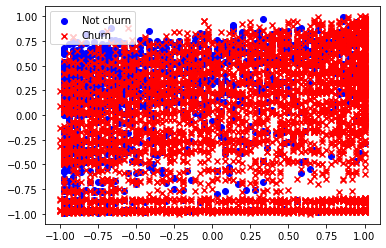

In [6]:
# Visualizing the data, uncomment "show()" to run it
pos = np.where(Y == 1)
neg = np.where(Y == 0)
scatter(X[pos, 0], X[pos, 1], marker='o', c='b')
scatter(X[neg, 0], X[neg, 1], marker='x', c='r')
# xlabel('Churn score')
# ylabel('Exam 2 score score')
legend(['Not churn', 'Churn'])
show()

In [7]:
##The sigmoid function adjusts the cost function hypotheses to adjust the algorithm proportionally for worse estimations
def Sigmoid(z):
    G_of_Z = float(1.0 / float((1.0 + math.exp(-1.0*z))))
    return G_of_Z 

##The hypothesis is the linear combination of all the known factors x[i] and their current estimated coefficients theta[i] 
##This hypothesis will be used to calculate each instance of the Cost Function
def Hypothesis(theta, x):
    z = 0
    for i in range(len(theta)):
        z += x[i]*theta[i]
    return Sigmoid(z)

##For each member of the dataset, the result (Y) determines which variation of the cost function is used
##The Y = 0 cost function punishes high probability estimations, and the Y = 1 it punishes low scores
##The "punishment" makes the change in the gradient of ThetaCurrent - Average(CostFunction(Dataset)) greater
def Cost_Function(X,Y,theta,m):
    sumOfErrors = 0
    for i in range(m):
        xi = X[i]
        hi = Hypothesis(theta,xi)
        if Y[i] == 1:
            error = Y[i] * math.log(hi)
        elif Y[i] == 0:
            error = (1-Y[i]) * math.log(1-hi)
        sumOfErrors += error
    const = -1/m
    J = const * sumOfErrors
    print ('cost is ', J )
    return J

##This function creates the gradient component for each Theta value 
##The gradient is the partial derivative by Theta of the current value of theta minus 
##a "learning speed factor aplha" times the average of all the cost functions for that theta
##For each Theta there is a cost function calculated for each member of the dataset
def Cost_Function_Derivative(X,Y,theta,j,m,alpha):
    sumErrors = 0
    for i in range(m):
        xi = X[i]
        xij = xi[j]
        hi = Hypothesis(theta,X[i])
        error = (hi - Y[i])*xij
        sumErrors += error
    m = len(Y)
    constant = float(alpha)/float(m)
    J = constant * sumErrors
    return J

##For each theta, the partial differential 
##The gradient, or vector from the current point in Theta-space (each theta value is its own dimension) to the more accurate point, 
##is the vector with each dimensional component being the partial differential for each theta value
def Gradient_Descent(X,Y,theta,m,alpha):
    new_theta = []
    constant = alpha/m
    for j in range(len(theta)):
        CFDerivative = Cost_Function_Derivative(X,Y,theta,j,m,alpha)
        new_theta_value = theta[j] - CFDerivative
        new_theta.append(new_theta_value)
    return new_theta

##The high level function for the LR algorithm which, for a number of steps (num_iters) finds gradients which take 
##the Theta values (coefficients of known factors) from an estimation closer (new_theta) to their "optimum estimation" which is the
##set of values best representing the system in a linear combination model
def Logistic_Regression(X,Y,alpha,theta,num_iters):
    m = len(Y)
    for x in range(num_iters):
        new_theta = Gradient_Descent(X,Y,theta,m,alpha)
        theta = new_theta
        if x % 100 == 0:
            #here the cost function is used to present the final hypothesis of the model in the same form for each gradient-step iteration
            Cost_Function(X,Y,theta,m)
            print ('theta ', theta)	
            print ('cost is ', Cost_Function(X,Y,theta,m))
    Declare_Winner(theta)

##This method compares the accuracy of the model generated by the scikit library with the model generated by this implementation
def Declare_Winner(theta):
    score = 0
    winner = ""
    #first scikit LR is tested for each independent var in the dataset and its prediction is compared against the dependent var
    #if the prediction is the same as the dataset measured value it counts as a point for thie scikit version of LR
    scikit_score = clf.score(X_test,Y_test)
    length = len(X_test)
    for i in range(length):
        prediction = round(Hypothesis(X_test[i],theta))
        answer = Y_test[i]
        if prediction == answer:
            score += 1
    #the same process is repeated for the implementation from this module and the scores compared to find the higher match-rate
    my_score = float(score) / float(length)
    if my_score > scikit_score:
        print ('You won!')
    elif my_score == scikit_score:
        print ('Its a tie!')
    else:
        print( 'Scikit won.. :(')
    print ('Your score: ', my_score)
    print ('Scikits score: ', scikit_score )


In [8]:
# These are the initial guesses for theta as well as the learning rate of the algorithm
# A learning rate too low will not close in on the most accurate values within a reasonable number of iterations
# An alpha too high might overshoot the accurate values or cause irratic guesses
# Each iteration increases model accuracy but with diminishing returns, 
# and takes a signficicant coefficient times O(n)*|Theta|, n = dataset length
initial_theta = [0,0]
alpha = 0.1
iterations = 1000
Logistic_Regression(X,Y,alpha,initial_theta,iterations)

cost is  0.6920019911288224
theta  [-0.00824380393456064, 0.006857322079083511]
cost is  0.6920019911288224
cost is  0.6920019911288224
cost is  0.6344106454254521
theta  [-0.543995991450706, 0.5207186447511538]
cost is  0.6344106454254521
cost is  0.6344106454254521
cost is  0.6203277115733387
theta  [-0.7815306330222745, 0.803855947673818]
cost is  0.6203277115733387
cost is  0.6203277115733387
cost is  0.6161623167440242
theta  [-0.9035915902975545, 0.9643562860612725]
cost is  0.6161623167440242
cost is  0.6161623167440242
cost is  0.6147965838108228
theta  [-0.971910357882387, 1.0576539001469587]
cost is  0.6147965838108228
cost is  0.6147965838108228
cost is  0.6143229178228266
theta  [-1.0118651274288637, 1.1128697317774559]
cost is  0.6143229178228266
cost is  0.6143229178228266
cost is  0.6141532674245933
theta  [-1.0357559787827442, 1.1459527731147452]
cost is  0.6141532674245933
cost is  0.6141532674245933
cost is  0.6140913398375067
theta  [-1.0502050024945668, 1.1659383429